In [97]:
%load_ext autoreload
%autoreload 2

import torch
import tqdm
import gpytorch


import numpy as np
from ase import io
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.append("../../fande") # Adds higher directory to python modules path.
sys.path.append("..") # Adds higher directory to python modules path.

In [100]:
path = os.getcwd()

print(path)

/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks


In [4]:
from fande.data import FandeDataModule

fande.models module imported...
FandE-GP imported  
objects of fande.data module imported...


### Parsing and loading data:

In [15]:
%load_ext autoreload
%autoreload 2

from sdynamics.load import parse_trajectories, parse_forces, flatten_trj_dictionaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
trajectories, energies_trj, trj_files_basenames = parse_trajectories(traj_folder="../data/dynamics/ene_grad_fitting/data/trj/")
forces_trj = parse_forces(forces_path = '../data/dynamics/ene_grad_fitting/data/grad/', trj_files_basenames = trj_files_basenames)

Reading trajectory files...


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]

Trajectory files reading done!
Reading .npy files with forces...
Reading .npy files with forces done!


In [33]:
traj, energies, forces = flatten_trj_dictionaries(trajectories, energies_trj, trj_files_basenames, forces_trj)

Flattening done!


### Prepare training/test datasets:

In [67]:
# Training data:
training_indices = np.sort(  np.random.choice(np.arange(0,92795), 2000, replace=False) ) 
traj_train = [traj[i] for i in training_indices]
energies_train = energies[training_indices]
forces_train = forces[training_indices]
train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

#Test data:
test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
traj_test = [traj[i] for i in test_indices]
energies_test = energies[test_indices]
forces_test = forces[test_indices]
test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

In [94]:
from fande.data import FandeDataModuleASE

soap_params = {
    'species': ["H", "C"],
    'periodic': False,
    'rcut': 5.0,
    'sigma': 0.5,
    'nmax': 5,
    'lmax': 5,
    'average': "outer",
    'crossover': True,
    'dtype': "float64",
    'n_jobs': 10
}

hparams = {
    "soap_params" : soap_params,
    'dtype' : 'float64',
    'device' : 'gpu'
}

In [117]:
fdm = FandeDataModuleASE(train_data, test_data, hparams)

In [124]:
fdm.calculate_invariants(soap_params)

Total length of train traj is 2000
Starting SOAP calculation...
SOAP calculation done!
Total length of test traj is 200
Starting SOAP calculation...
SOAP calculation done!
(2000, 17, 3, 330)
(2000, 330)


### Fitting Forces:

In [132]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning import Trainer, seed_everything
import numpy as np
# seed_everything(42, workers=True)

train_DX = fdm.train_DX
train_F = fdm.train_F
test_DX = fdm.test_DX
test_F = fdm.test_F

# ind_slice = np.sort( np.concatenate( 
#     ( np.arange(0,4800), np.arange(11*4800,12*4800), np.random.choice(np.arange(4800,59200), 300, replace=False) ) 
#     ) )

# ind_slice = np.sort(  np.random.choice(np.arange(0,59200), 2000, replace=False) ) 
ind_slice = np.sort(  np.arange(0,2000) ) 

train_dataset = TensorDataset(train_DX[ind_slice], train_F[ind_slice])
train_loader = DataLoader(train_dataset, batch_size=100_000)

model_f = ModelForces(train_DX[ind_slice], train_F[ind_slice], hparams, 0.05)

trainer_f = Trainer(
    gpus=1, 
    max_epochs=170, 
    precision=64,
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_f.fit(model_f, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                                                   | Type                       | Params
------------------------------------------------------------------------------------------------------
0 | likelihood                                             | GaussianLikelihood         | 1     
1 | likelihood.noise_covar                                 | HomoskedasticNoise         | 1     
2 | likelihood.noise_covar.raw_noise_constraint            | GreaterThan                | 0     
3 | likelihood.noise_covar.raw_noise_constraint._transform | Softplus                   | 0     
4 | model                                                  | ExactGPModelForces         | 2     
5 | model.mean_module                                      | ZeroMean                   | 0     
6 | model.covar_module                                     | Linea


 setup() callback called...
Epoch 169: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s, loss=-1.4, v_num=4]   

 teardown() callback called...


### Predictions on test data:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.




 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...


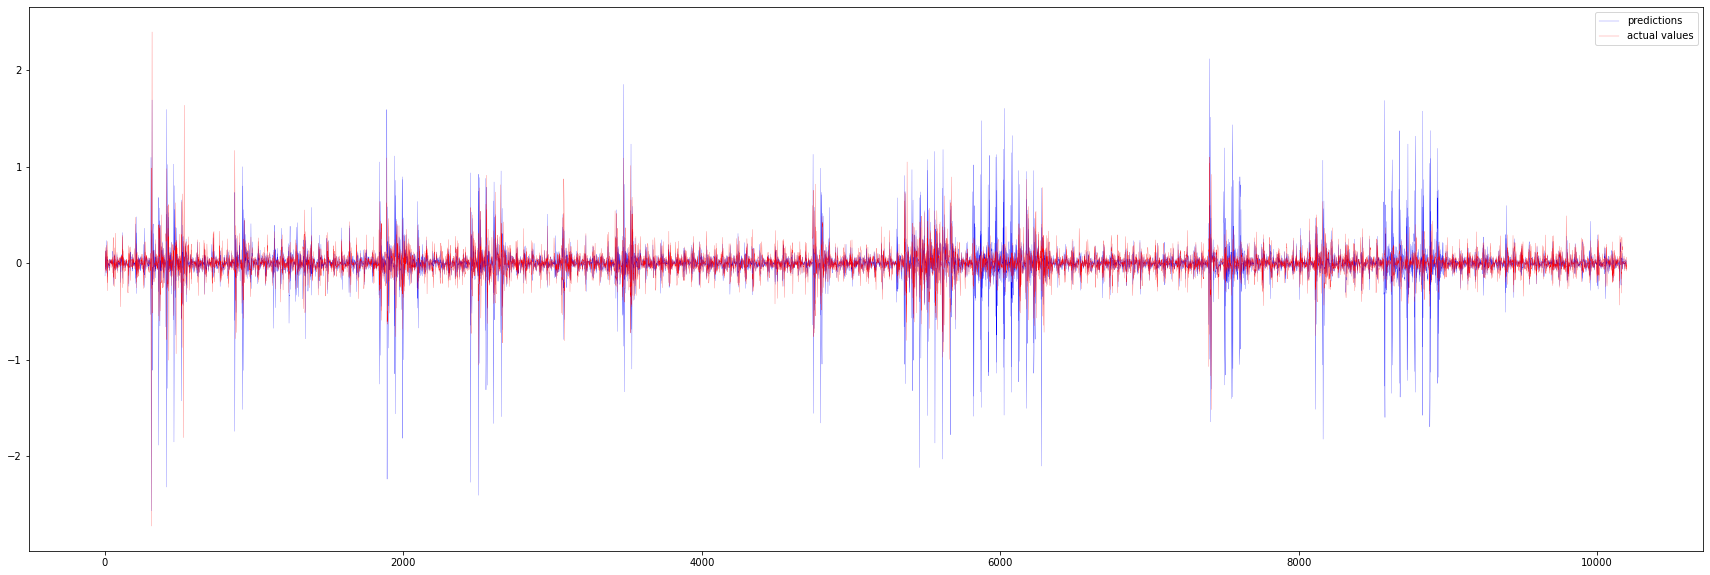

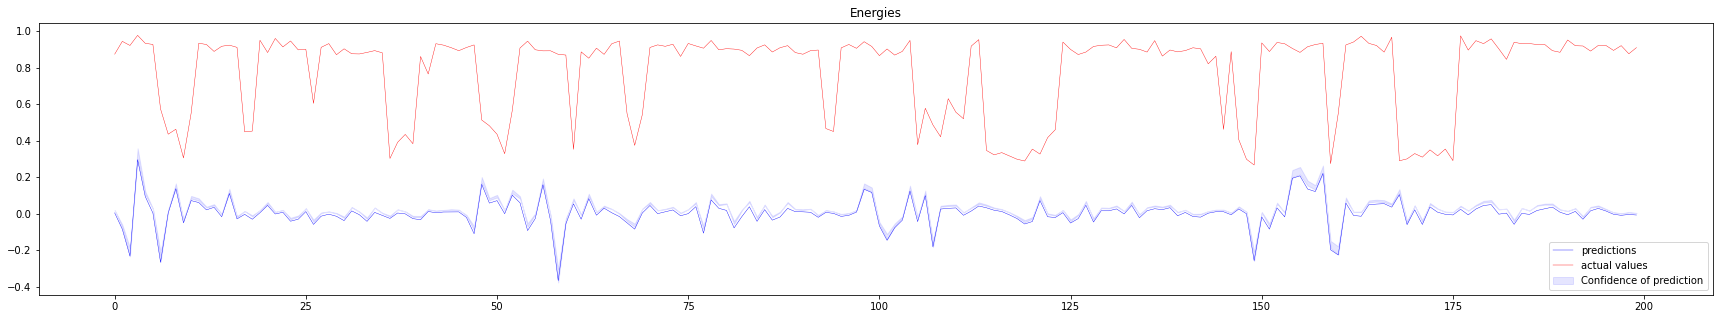

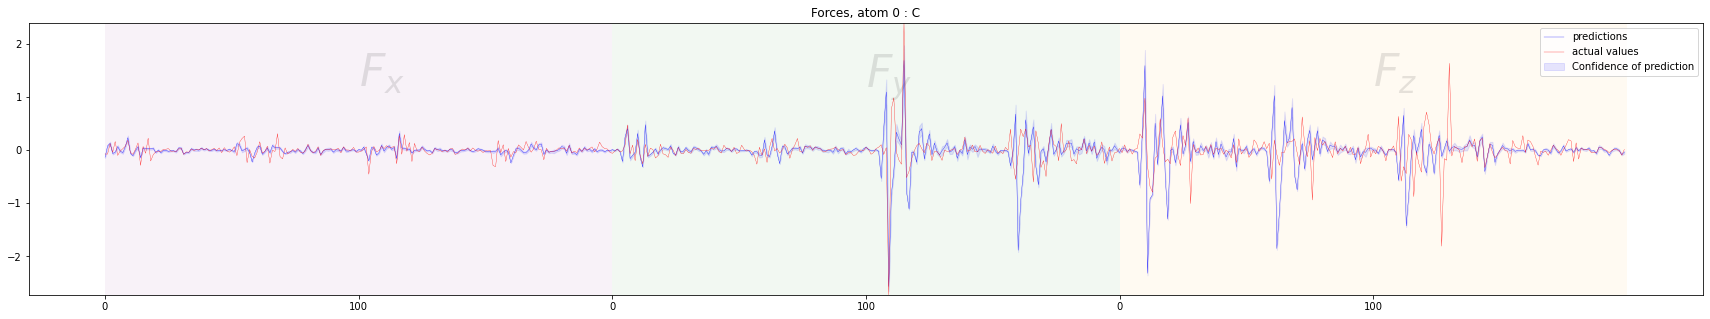

Forces MAE: 0.1471
Forces MSE: 0.0956
Cumulative uncertainty: 41.3584


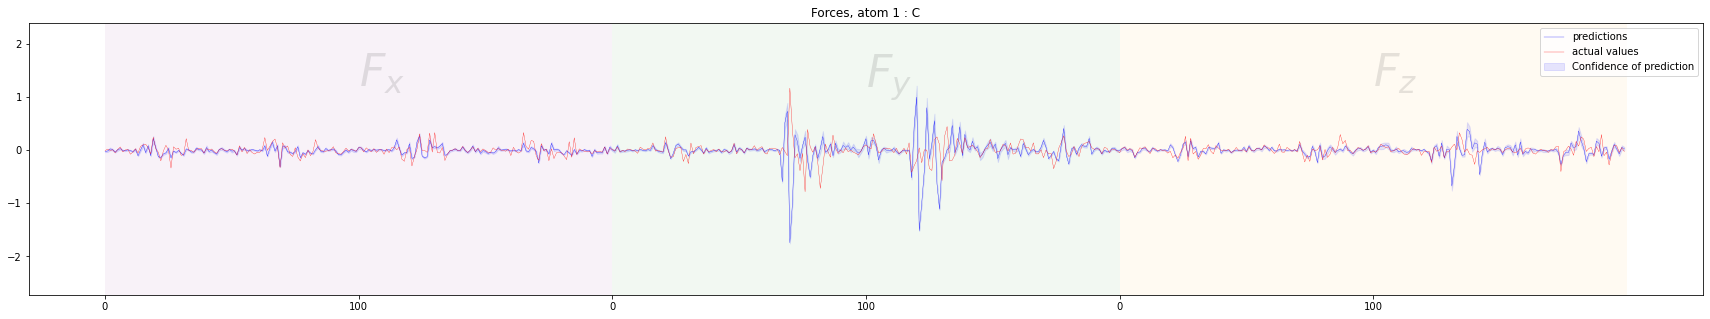

Forces MAE: 0.0924
Forces MSE: 0.0490
Cumulative uncertainty: 33.6652


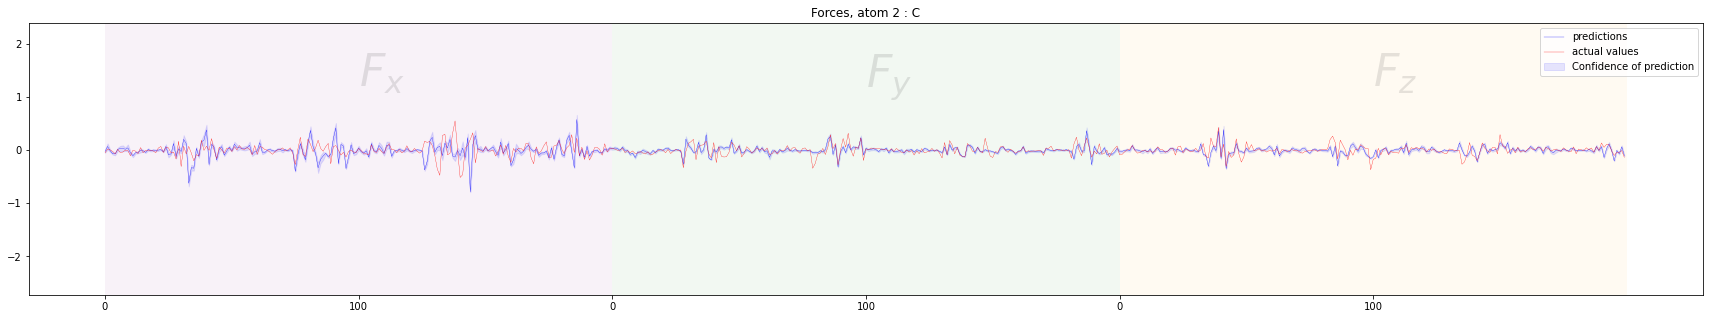

Forces MAE: 0.0725
Forces MSE: 0.0150
Cumulative uncertainty: 32.8824


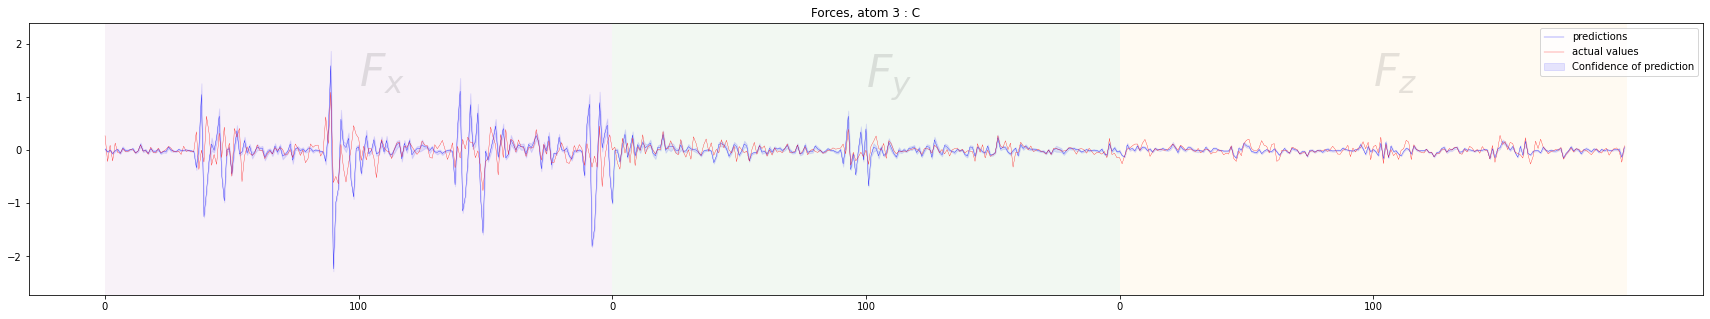

Forces MAE: 0.1206
Forces MSE: 0.0606
Cumulative uncertainty: 38.4341


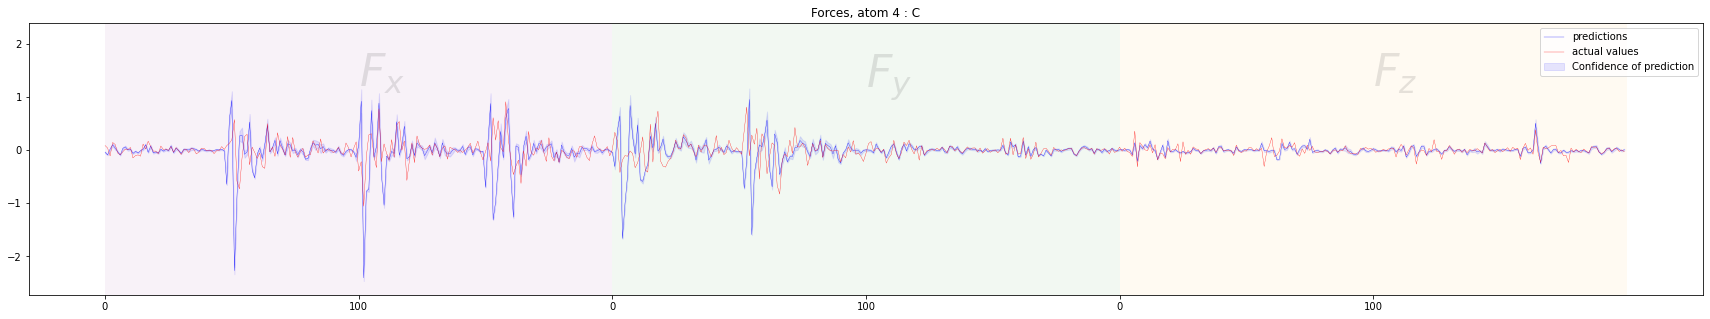

Forces MAE: 0.1294
Forces MSE: 0.0853
Cumulative uncertainty: 39.0795


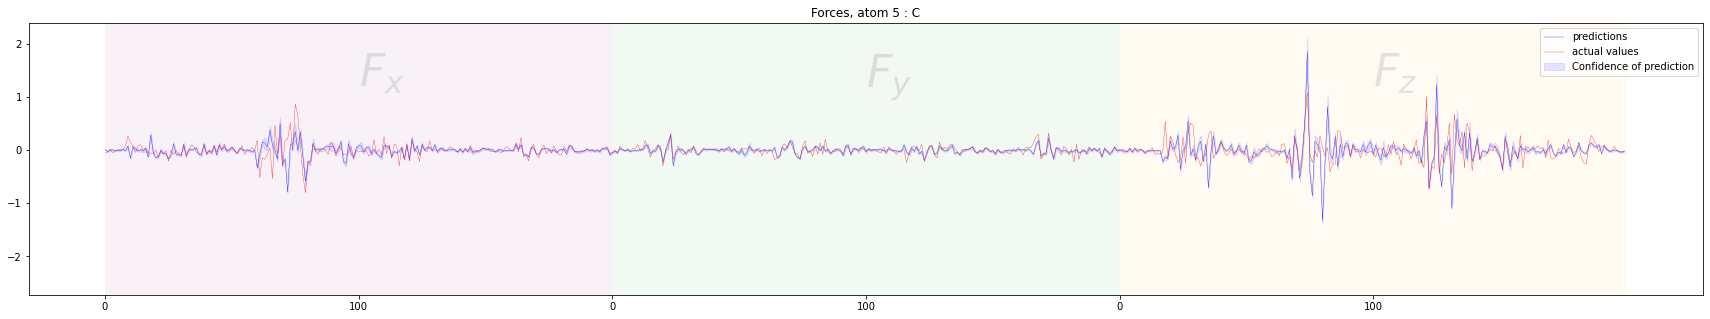

Forces MAE: 0.0940
Forces MSE: 0.0312
Cumulative uncertainty: 39.0025


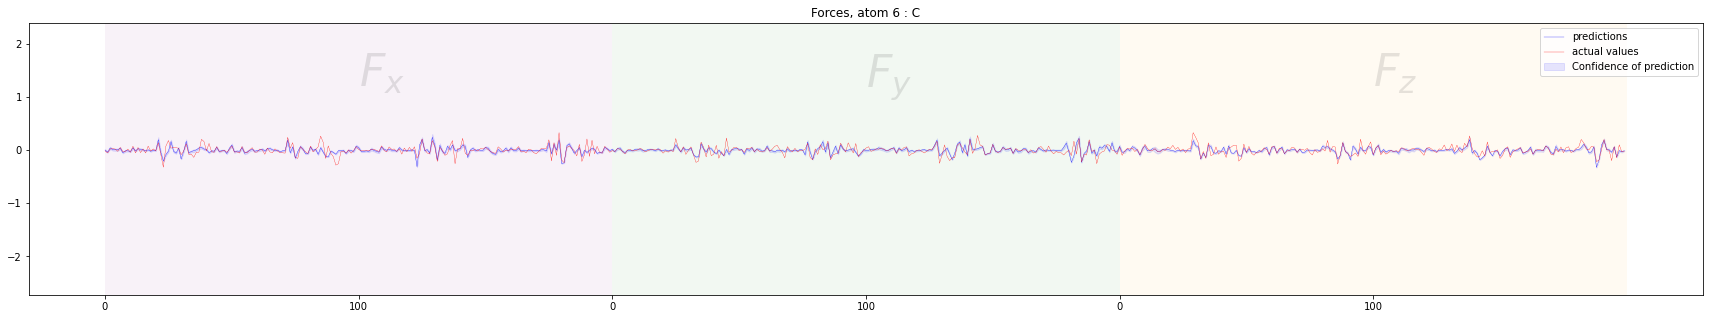

Forces MAE: 0.0448
Forces MSE: 0.0043
Cumulative uncertainty: 21.7463


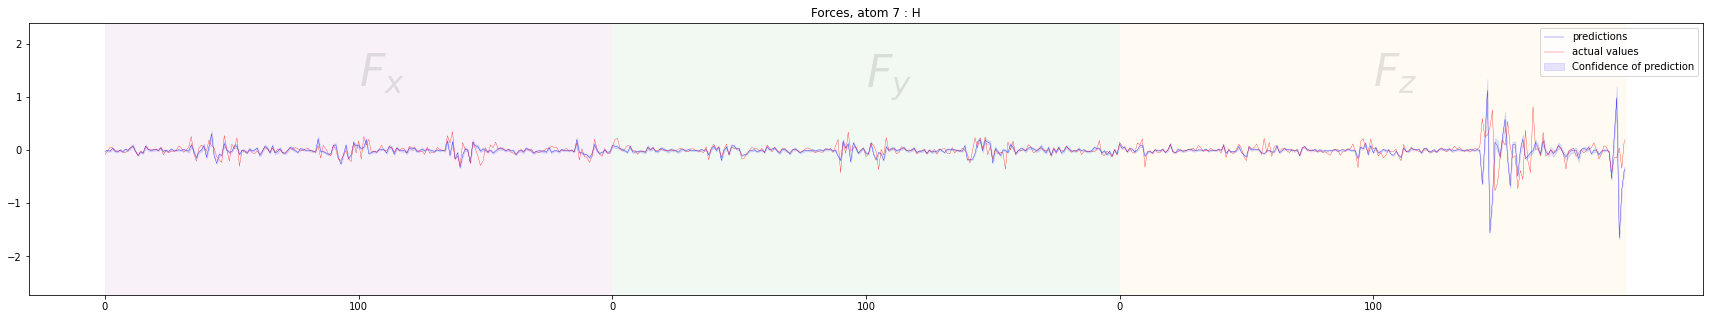

Forces MAE: 0.0742
Forces MSE: 0.0358
Cumulative uncertainty: 24.8614


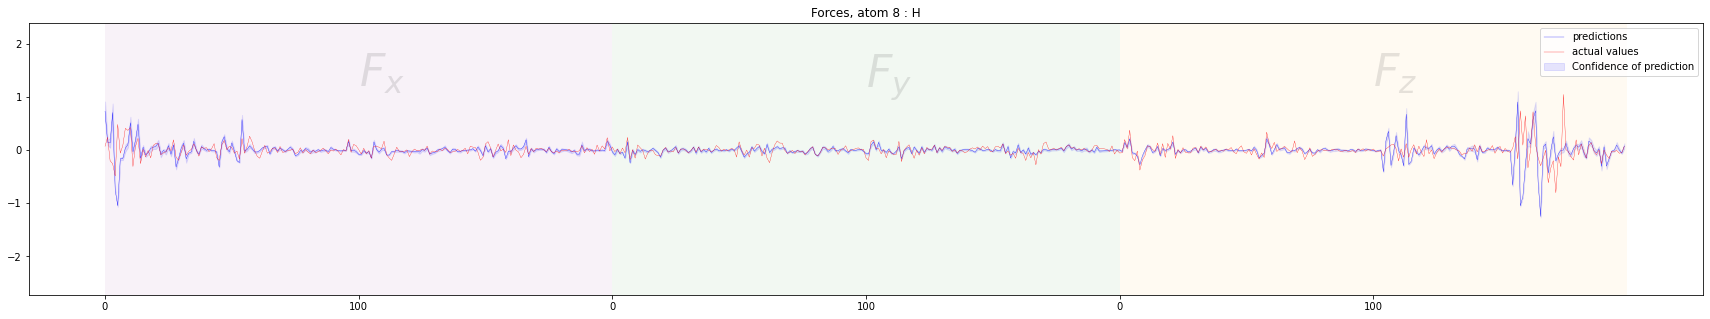

Forces MAE: 0.0773
Forces MSE: 0.0303
Cumulative uncertainty: 29.8863


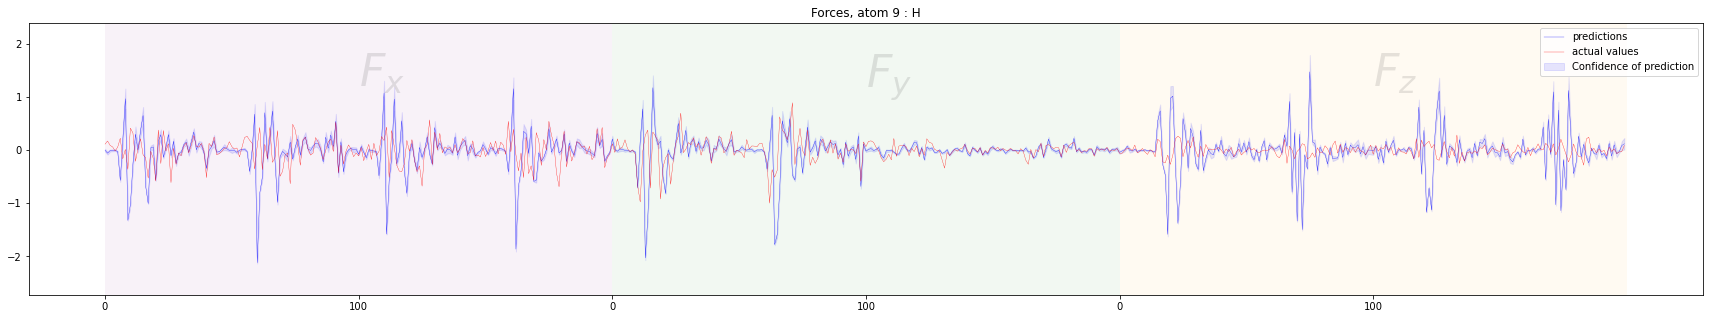

Forces MAE: 0.2189
Forces MSE: 0.1686
Cumulative uncertainty: 57.9851


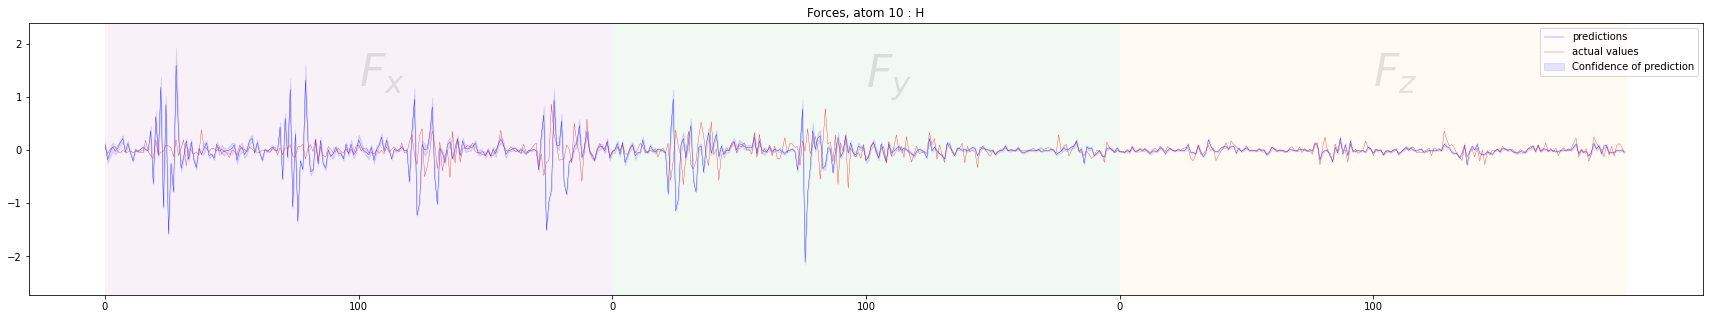

Forces MAE: 0.1526
Forces MSE: 0.0957
Cumulative uncertainty: 43.0859


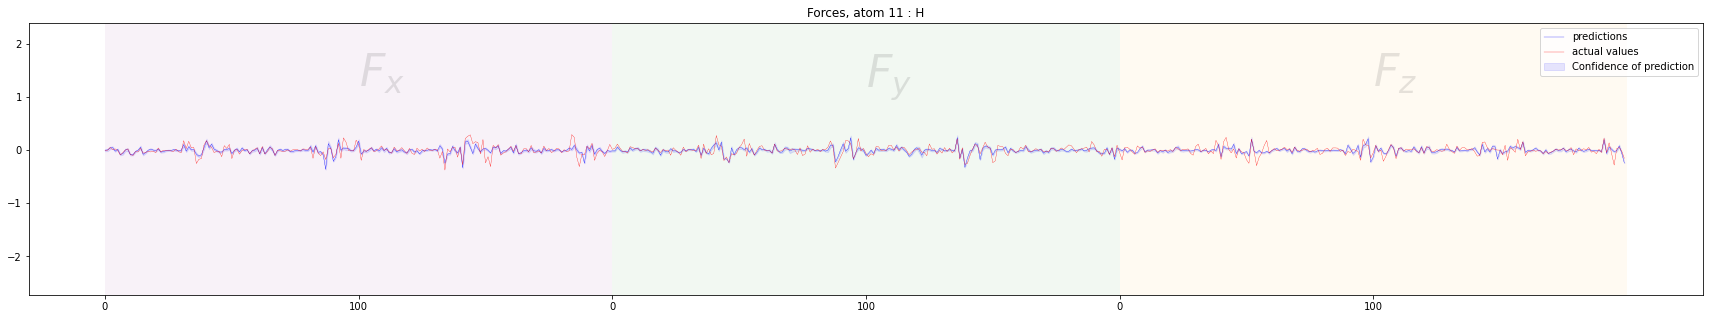

Forces MAE: 0.0448
Forces MSE: 0.0044
Cumulative uncertainty: 22.3117


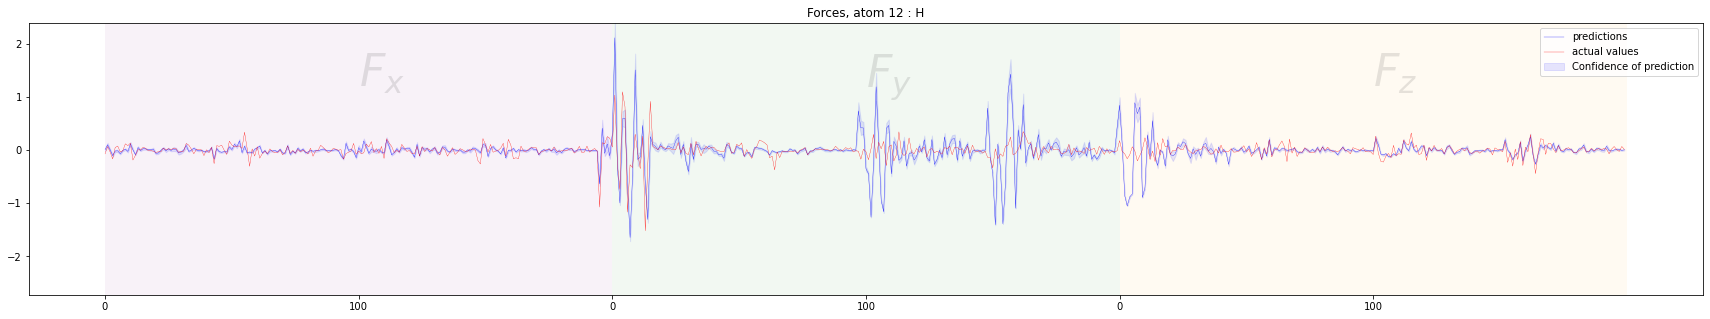

Forces MAE: 0.1221
Forces MSE: 0.0651
Cumulative uncertainty: 39.8562


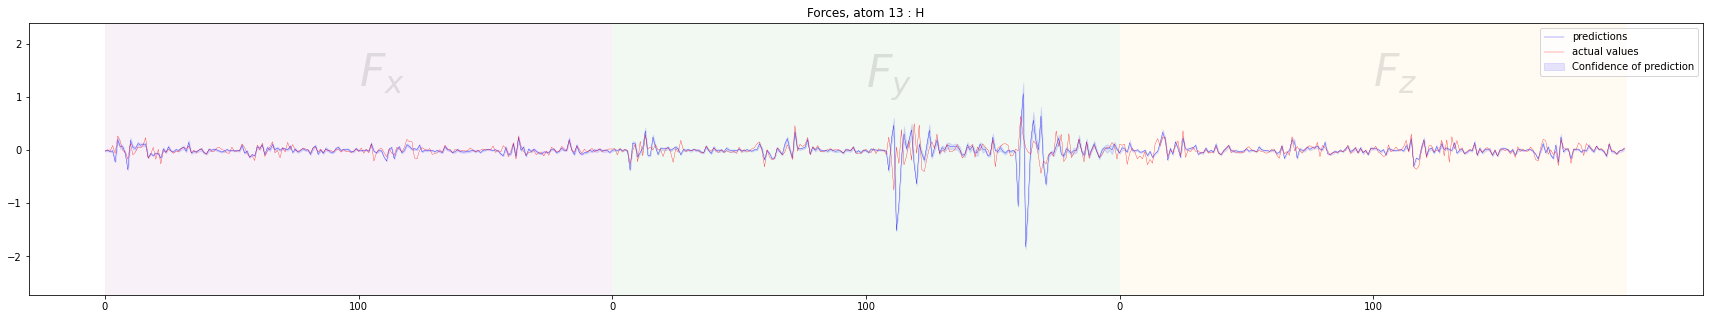

Forces MAE: 0.0767
Forces MSE: 0.0308
Cumulative uncertainty: 28.5225


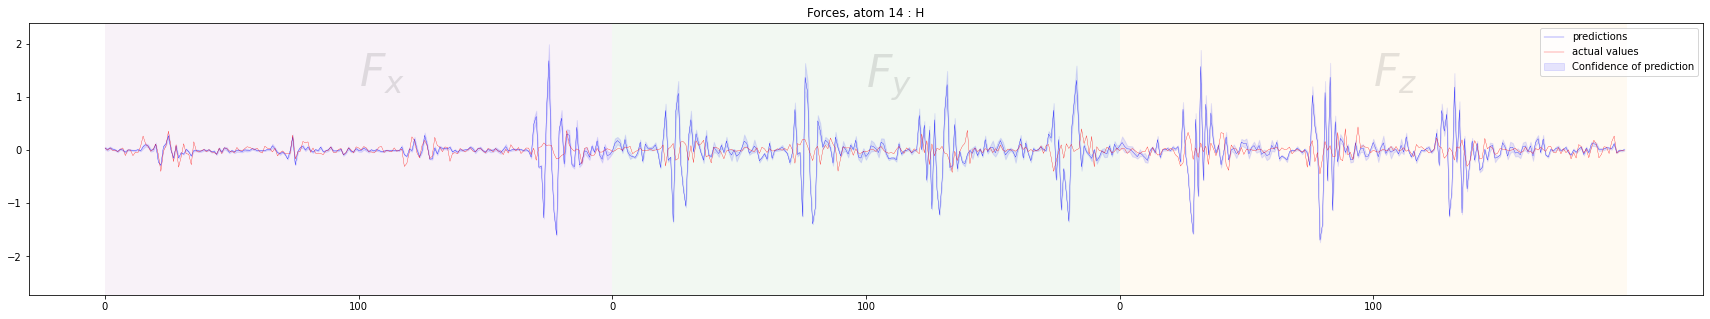

Forces MAE: 0.1955
Forces MSE: 0.1344
Cumulative uncertainty: 51.6119


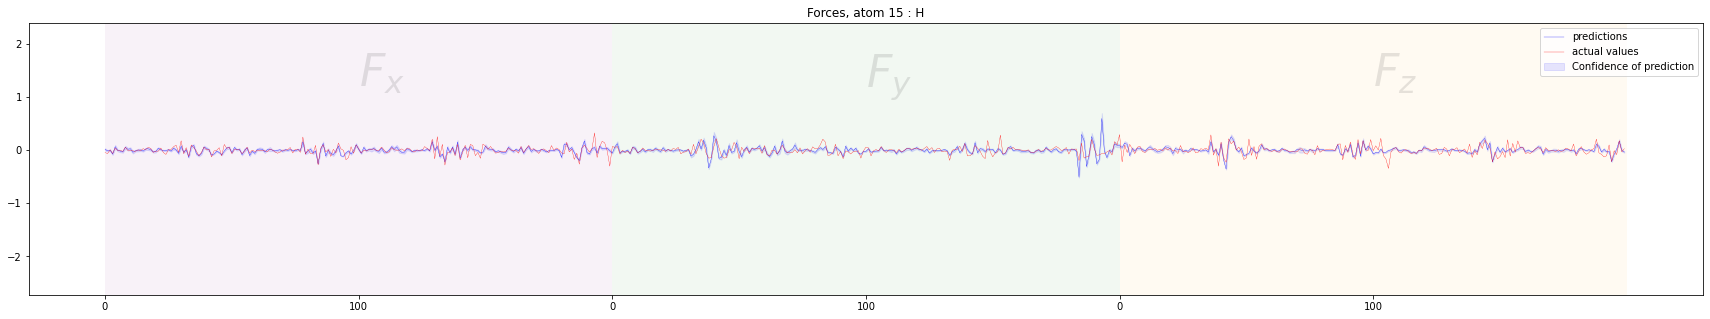

Forces MAE: 0.0505
Forces MSE: 0.0060
Cumulative uncertainty: 25.0013


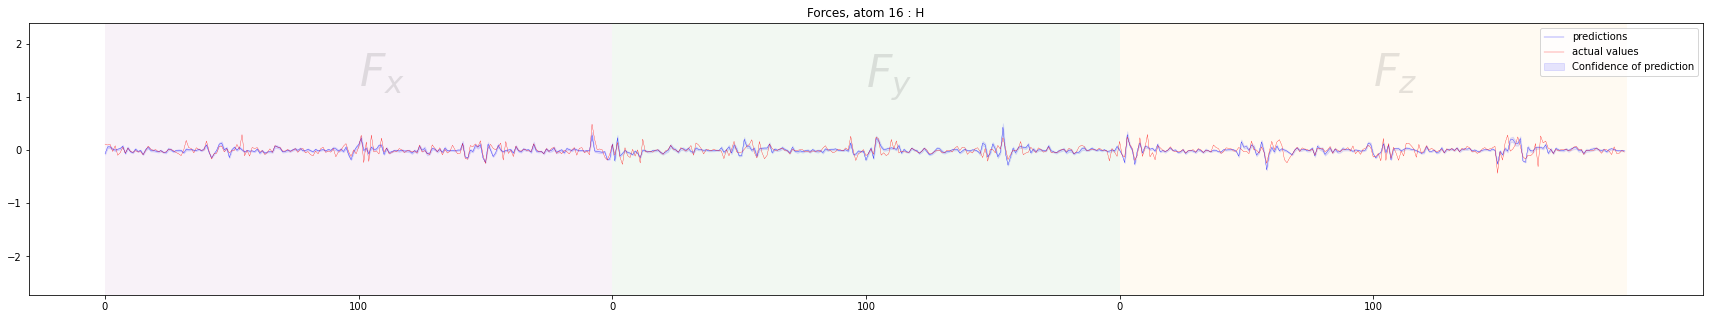

Forces MAE: 0.0501
Forces MSE: 0.0054
Cumulative uncertainty: 22.3677


In [135]:
from fande.predict import PredictorASE

test_X = fdm.test_X
test_DX = fdm.test_DX
test_E = fdm.test_E
test_F = fdm.test_F

model_e = None
trainer_e = None


predictor = PredictorASE(
            model_e,
            model_f,
            trainer_e,
            trainer_f,
            test_X,
            test_DX,
            test_E,
            test_F,
            test_data,
            hparams
)

predictor.predict_and_plot_forces()

### Dynamics simulation

In [ ]:
from sdynamics.dynamics import MDynamics

atoms = ... # initialize saddle structure

atoms.calc = gp_model.ase_calc() # get calc from the trained GP

md_runner = MDynamics(atoms) # instantiate class for running MD

md_runner.run() # run the MD

### Visualize:

In [136]:
from ase.visualize import view

# trj = trajectories[trj_files_basename[2]]
view(traj[0:100])

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>